In [1]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")
import pymc3 as pm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as tt

In [151]:
# some test data
x = np.random.randn(20)
m = np.zeros(20)
K = pm.gp.cov.ExpQuad(1, 0.2)(np.linspace(0,1,20)[:,None]).eval() + np.eye(20)*1e-6
L = np.linalg.cholesky(K)

In [153]:
# check math on variable transformation
print(sp.stats.multivariate_normal.logpdf(x, m, K))
logp = sum(sp.stats.norm.logpdf(sp.linalg.solve_triangular(L, x, lower=True), 
                                m, np.ones(20)))
det = -1.0 * np.sum(np.log(np.diag(L)))
print(logp + det)

-2909245.70798
-2909245.70803


## Playing with Interval transform

In [154]:
with pm.Model() as model:
    x = pm.Uniform("x", lower=0, upper=1)
    tr = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 0.071552:   2%|▏         | 4517/200000 [00:00<00:17, 11306.18it/s]
Convergence archived at 5000
Interrupted at 5,000 [2%]: Average Loss = 0.18915
100%|██████████| 1500/1500 [00:00<00:00, 2450.41it/s]


In [155]:
xv = tr[0]["x"]
xt = tr[0]["x_interval__"]
print("original:", xv, ", transformed:", xt)

original: 0.769278993223 , transformed: 1.20424448602


In [157]:
a = 0; b = 1;
print("transformed -> original:", ((b - a) * tt.nnet.sigmoid(xt) + a).eval()) # backward
print("original -> transformed:",  (tt.log(xv - a) - tt.log(b - xv)).eval())  # forward
# backward

transformed -> original: 0.7692789932227813
original -> transformed: 1.2042444860199981


## Rotated MvNormal

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 0.23736:   2%|▏         | 3135/200000 [00:00<00:18, 10425.64it/s]
Convergence archived at 3900
Interrupted at 3,900 [1%]: Average Loss = 0.63092
 99%|█████████▊| 691/700 [00:01<00:00, 689.26it/s]/home/bill/pymc3/pymc3/step_methods/hmc/nuts.py:418: UserWarning: Chain 0 contains only 200 samples.
  % (self._chain_id, n))
100%|██████████| 700/700 [00:01<00:00, 597.62it/s]


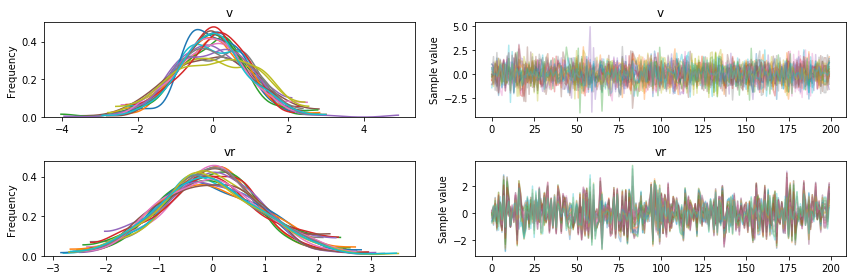

In [144]:
L = np.linalg.cholesky(K)
with pm.Model() as model:
    v = pm.Normal("v", mu=0.0, sd=1.0, shape=(20,))
    x = pm.Deterministic("vr", tt.dot(L,v))
    tr = pm.sample(200)
pm.traceplot(tr);

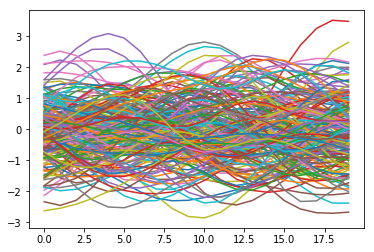

In [145]:
for i in range(len(tr)):
    x = tr[i]["vr"]
    plt.plot(x);

## As a transform

In [223]:
from pymc3.distributions.transforms import Transform
from pymc3.distributions.continuous import Continuous

class RotateStandardNormal(Transform):
    name = "rotated"
    def __init__(self, chol):
        self.chol = tt.as_tensor_variable(chol)
        self.solve_lower = tt.slinalg.Solve(A_structure="lower_triangular")
    def forward(self, x): 
        return tt.dot(self.chol, x)
    def backward(self, y): 
        return self.solve_lower(self.chol, y)
    def forward_val(self, x, point=None):
        return self.forward(x)
    def jacobian_det(self, x): 
        return -1.0 * tt.sum(tt.log(tt.diag(self.chol)))
rotated = RotateStandardNormal

class MvNormal(pm.Continuous):
    def __init__(self, parameterization=None, chol=None, *args, **kwargs):
        if parameterization == 'rotated':
            transform = rotated(chol)
        else:
            transform = None
        super(MvNormal, self).__init__(transform=transform, *args, **kwargs)
        # hackyness
        self.mean = self.mode = self.median = np.zeros(20)
        self.variance = np.ones(20)
    def logp(self, x):
        return - 0.5 * (x ** 2 + tt.log(2 * np.pi))

In [224]:
K = pm.gp.cov.ExpQuad(1, 0.2)(np.linspace(0,1,20)[:,None]).eval() + np.eye(20)*1e-6
L = np.linalg.cholesky(K)
with pm.Model() as model:
    v = MvNormal("v", parameterization='rotated', chol=L, shape=20)
    tr = pm.sample(200)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,373.6:  20%|█▉        | 39555/200000 [00:09<00:40, 3938.35it/s]  
Convergence archived at 39800
Interrupted at 39,800 [19%]: Average Loss = 1.7094e+05
100%|██████████| 700/700 [04:00<00:00,  2.84it/s]/home/bill/pymc3/pymc3/step_methods/hmc/nuts.py:418: UserWarning: Chain 0 contains only 200 samples.
  % (self._chain_id, n))
/home/bill/pymc3/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



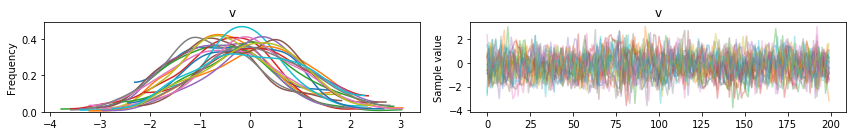

In [225]:
pm.traceplot(tr);

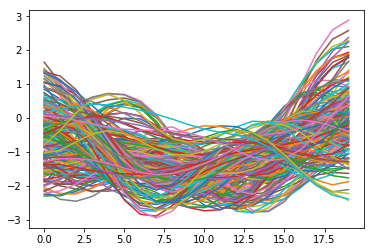

In [226]:
for i in range(len(tr)):
    x = tr[i]["v_rotated__"]
    plt.plot(x);

In [229]:
model.profile(model.logpt).summary()

Function profiling
  Message: /home/bill/pymc3/pymc3/model.py:617
  Time in 2000 calls to Function.__call__: 2.160830e-01s
  Time in Function.fn.__call__: 1.726398e-01s (79.895%)
  Time in thunks: 1.660867e-01s (76.862%)
  Total compile time: 9.704351e-02s
    Number of Apply nodes: 3
    Theano Optimizer time: 5.995321e-02s
       Theano validate time: 5.278587e-04s
    Theano Linker time (includes C, CUDA code generation/compiling): 2.989769e-03s
       Import time 0.000000e+00s
       Node make_thunk time 2.581358e-03s
           Node Elemwise{Composite{(i0 + (i1 * (i2 + sqr(i3))))}}[(0, 3)](TensorConstant{(1,) of 75..2988819639}, TensorConstant{(1,) of -0.5}, TensorConstant{(1,) of 1...3787706641}, Solve{A_structure='lower_triangular', lower=False, overwrite_A=False, overwrite_b=False}.0) time 1.076937e-03s
           Node Solve{A_structure='lower_triangular', lower=False, overwrite_A=False, overwrite_b=False}(TensorConstant{[[  1.0000..8552e-02]]}, v_rotated__) time 1.018047e-03s


In [227]:
x = np.random.randn(20)
%timeit sp.linalg.solve_triangular(L, x, lower=True)
%timeit np.dot(L, x)

67 µs ± 813 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
994 ns ± 5.86 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


- this is MUCH slower than setting the `Deterministic` in the model. why?
- `logp` is fast, but NUTS has a really hard time sampling
- how I did this is the reverse of how `Uniform` + `Interval` was done... wrong?
- although the samples look 'correct', judging from the plot they are extremely correlated
- `backward`, which is where the solve is, gets called each time logp is evaluated, see in `TransformedDistribution`, line 79 of `transforms.py`.